In [1]:
# Import required libraries
import numpy as np
from scipy.linalg import expm, logm, sqrtm
import matplotlib.pyplot as plt
import h5py
import os
import seaborn as sns
import pandas as pd
from qutip import fidelity,Qobj
# Working directories
script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = script_dir#os.path.join(script_dir, 'Data/')
graphs_dir = os.path.join(script_dir, 'Graphs/')

In [2]:
def fidelity_diy(rho,sigma):
    rho_sqrt = sqrtm(rho)
    mat = np.matmul(np.matmul(rho_sqrt, sigma), rho_sqrt)
    F = np.sum(np.sqrt(np.clip(np.linalg.eigh(mat)[0].real, 0, 1))) ** 2
    return F

In [3]:
# Set plotting style
plt.rcParams["figure.figsize"] = (5.3,3)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600

sns.axes_style("whitegrid")
sns.set_context("paper")
sns.set_palette("rocket")

In [4]:
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format="Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")

    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp
            if format != "shortendtruncSeed":
                F_best = f[grp]['F'].attrs['F_best'] 
                F_last = f[grp]['F'][:][-1]
            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            #row.append(float(F_best))
            row.append(float(F_last))
            
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            row.append(np.shape(f[grp]['F'][:])[0])
            row.append(f[grp]["G"][-1])
            """Beta_arr
            if not f[grp]["G"]:
                row.append(f[grp]["G"][-1])
            else:
                row.append(0)
            """
            data.append(row)
            
    df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit","FinalCost"])#
    return df
def read_dataS(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format = "Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    
    #grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+"__seed_"+str(seed)+ "/")
    
    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp
            F_best = f[grp]['F'].attrs['F_best'] 
            F_last = f[grp]['F'][:][-1]
            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            #row.append(float(F_best))
            row.append(float(F_last))
            
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            row.append(np.shape(f[grp]['F'][:])[0])
            
            
            data.append(row)
            
    df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit"])
    return df
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,format="Kristina"):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "GPU":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
      
    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    
    hdf5_files = [f for f in os.listdir(grid_dir) if not f.endswith('.txt')]
    data = []
    
    for file_num, filename in enumerate(hdf5_files): 
        #print(filename)
        f = h5py.File(grid_dir + str(filename), 'r')
        
        row = []
        for grp in f.keys():
            settings = f[grp].attrs['Settings']
            #print(settings)
            beta = grp

            
            row.append(beta) 
            row.append(N)
            row.append(m)
            row.append(model)
            row.append(ansatz) 
            row.append(error_channel) 
            row.append(entropy_method) 
            row.append(optimizer) 
            row.append(n_epochs)
            row.append(n_fev) 
            row.append(seed) 
            row.append(multierror) 
            rho_target = f[grp]['rho_target'][:]
            rho_final = f[grp]['rho_final'][:]

            if format != "GPU":
                F_best = f[grp]['F'].attrs['F_best'] 
                F_last = f[grp]['F'][:][-1]
                #row.append(float(F_best))
                row.append(float(F_last))
                print(float(fidelity(Qobj(rho_target),Qobj(rho_final))),float(F_last),fidelity_diy(rho_target,rho_final))
            else: row.append(float(fidelity(Qobj(rho_target),Qobj(rho_final))))
            
            S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
            #print(S_cross)
            S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
            #print(S_target)
            S_cross_scaled = S_cross / S_target
            S_cross_diff = np.abs(S_cross - S_target)
            
            row.append(float(S_cross_scaled))
            row.append(float(S_cross_diff))
            #print(S_cross_scaled)
            #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                  
            #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
            #print(S_HS)
            
            TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
            
            row.append(np.real(TD))
            if format != "GPU": row.append(np.shape(f[grp]['F'][:])[0])
        
            row.append(f[grp]["G"][-1])
            """Beta_arr
            if not f[grp]["G"]:
                row.append(f[grp]["G"][-1])
            else:
                row.append(0)
            """
            data.append(row)
            
    if format != "GPU": df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"Nit","FinalCost"])#
    else: df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross', 'S_cross_diff', 'TD',"FinalCost"])#
    
    return df

In [5]:
def create_data_frame(frames):
    df = pd.concat(frames, ignore_index=True)

    df['beta']= df['beta'].astype(float)
    df['N']= df['N'].astype(int)
    df['m']= df['m'].astype(int)
    df['model']= df['model'].astype(str)
    df['ansatz']= df['ansatz'].astype(str)
    df['error_channel']= df['error_channel'].astype(str)
    df['entropy_method']= df['entropy_method'].astype(str)
    df['optimizer']= df['optimizer'].astype(str)
    df['n_epochs']= df['n_epochs'].astype(str)
    df['n_fev']= df['n_fev'].astype(str)
    df['seed']= df['seed'].astype(int)
    df['multierror']= df['multierror'].astype(str)
    df['F']= df['F'].astype(float)
    df['S_cross']= df['S_cross'].astype(float)
    
    df['S_cross_diff']= df['S_cross_diff'].astype(float)
    df['TD']= df['TD'].astype(float)
    
    


    return df
def create_data_frame(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)
        df['Nit']= df['Nit'].astype(float)
        df['FinalCost']= df['FinalCost'].astype(float)

        return df
def create_data_frame_GPU(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)

        df['FinalCost']= df['FinalCost'].astype(float)

        return df

In [8]:
Beta_arr = [1e-2, 0.05,0.1,0.25,0.5,0.75,1,2,5,10]#np.logspace
#Beta_arr = Beta_arr[5:]
Seed_arr = [1,2,3,4,5]
#! !python -W ignore main.py  -N 3 -m 2 -model HDm2  -ansatz Hmultic  -initialization random-gaussian -error_channel phaseflip  -p_err 0.01 -entropy_method exact -optimizer L-BFGS-B -tol 1e-08 -seed S  -lambdas B

In [9]:
frames = []

N_list = [6]
m_list = [3]
model_list = ["Heisenberg"]
ansatz_list = ["sym_TFIM"]#,"Hmultic_RS" #"Hmultic"#made a special ansatz so that I did not have to change the running one. 
error_channel_list = ["phaseflip"]
entropy_method_list = ["disentangle","exact","approx-D"]
optimizer_list = ["COBYLA","L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5,6,7,8,9,10]
multierror_list = ["no"]

for N in N_list:
    for m in m_list:
        #if m    
            for model in model_list:
                for ansatz in ansatz_list:
                    for error_channel in error_channel_list:
                        for entropy_method in entropy_method_list:
                            for optimizer in optimizer_list:
                                for n_epochs in n_epochs_list:
                                    for n_fev in n_fev_list:
                                        for seed in seeds:
                                            for multierror in multierror_list:
                                                    if entropy_method == "disentangle" and optimizer == "COBYLA":
                                                        frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))
                                                    elif (entropy_method == "exact" or entropy_method == "approx-D") and optimizer == "L-BFGS-B":
                                                        if entropy_method == "approx-D":
                                                             ansatz = "qaoa-r-layers"
                                                        frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,format="shortendtruncSeed"))
                                                    
                                            
df = create_data_frame(frames)




0.9104119981967744 0.8288500064605827 0.8288500064601908
0.9492887051487513 0.901149045722992 0.9011490457229944
0.9996797314963387 0.9993595655645914 0.999359565564594
0.9659007840217755 0.9329643245738815 0.9329643245738817
0.5331166200206592 0.2842133305420328 0.2842133305421091
0.5012516122459727 0.25124505112735007 0.2512888288335895
0.9408062491026047 0.885116404560308 0.8851164431887405
0.9984836138653821 0.9969688371235967 0.9970117241268874
0.792811346658902 0.6285498313911017 0.628549831391102
0.9986907562046072 0.997383266112577 0.9974130702220715
0.8833960466733951 0.7803885752780851 0.7803885752790626
0.9864267966023577 0.9730378250551878 0.9730378250551895
0.999810708450926 0.9996214527331426 0.9996214527331453
0.9887295260430385 0.9775860756692915 0.9775860756692919
0.9060512396180924 0.8209288490271689 0.820928851942836
0.7464795537115599 0.5572203288483716 0.5572667791916552
0.9466397244833318 0.8961267671616481 0.8961267827801997
0.9983380108651805 0.9966751326328702 

      beta  N  m       model         ansatz error_channel  \
0     0.50  6  3  Heisenberg       sym_TFIM     phaseflip   
1     0.05  6  3  Heisenberg       sym_TFIM     phaseflip   
2     0.01  6  3  Heisenberg       sym_TFIM     phaseflip   
3     0.10  6  3  Heisenberg       sym_TFIM     phaseflip   
4     0.75  6  3  Heisenberg       sym_TFIM     phaseflip   
..     ... .. ..         ...            ...           ...   
285   2.00  6  3  Heisenberg  qaoa-r-layers     phaseflip   
286   1.00  6  3  Heisenberg  qaoa-r-layers     phaseflip   
287   5.00  6  3  Heisenberg  qaoa-r-layers     phaseflip   
288   0.25  6  3  Heisenberg  qaoa-r-layers     phaseflip   
289  10.00  6  3  Heisenberg  qaoa-r-layers     phaseflip   

             entropy_method optimizer n_epochs  n_fev  seed multierror  \
0    variational estimation    COBYLA       50  10000     1         no   
1    variational estimation    COBYLA       50  10000     1         no   
2    variational estimation    COBYLA       5

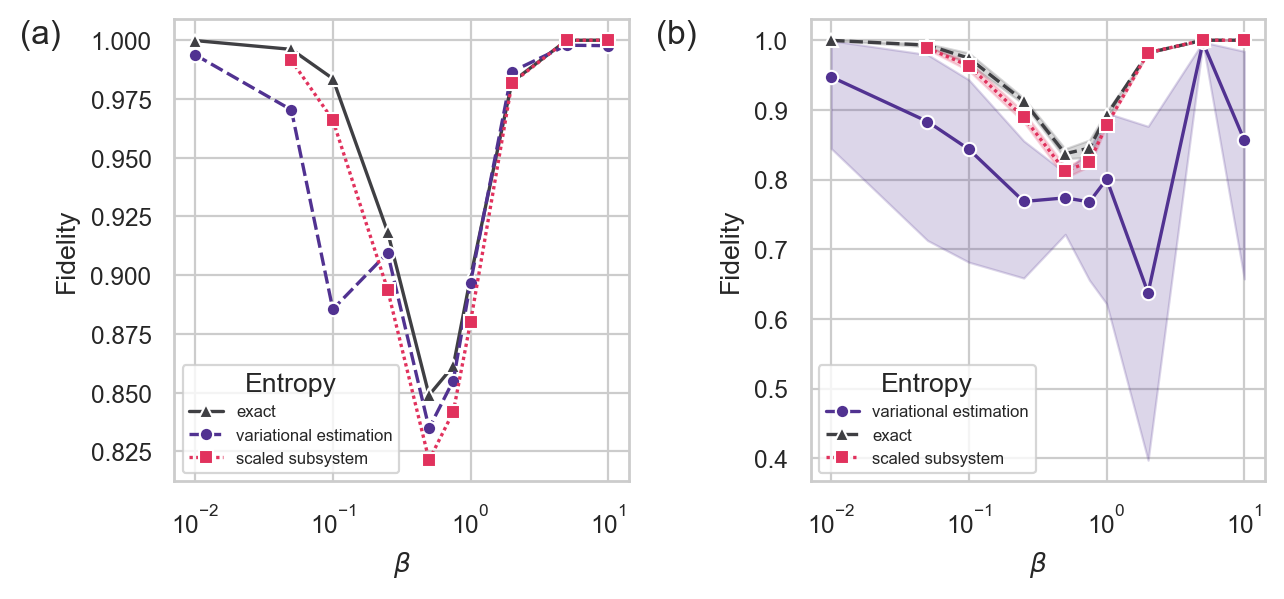

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
 
# Define colors for entropy methods
colors = {'scaled subsystem': "#E1325D","variational estimation":"#513291", "exact": "#3F3F43"}
markersdic = {'scaled subsystem': "s","variational estimation":"o", "exact": "^"}

df1 = df
df1['entropy_method'] = df1['entropy_method'].replace({"disentangle":"variational estimation","exact":"exact","approx-D":'scaled subsystem'})
print(df1)
# Set figure size and style
plt.figure(figsize=(17.8/2.53, 3))
plt.rcParams["figure.figsize"] = (17.8/2.53,2*3/2.54)
mpl.rcParams.update({'font.size': 6})
sns.set_style("whitegrid")

# Plot first subplot
plt.subplot(1, 2, 1)
df_max = df1.loc[df1.groupby(['beta', 'entropy_method'])['FinalCost'].idxmin()]
sns.lineplot(data=df_max, x='beta', y='F', style='entropy_method', hue="entropy_method", markers=markersdic, palette=colors)

plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')
plt.legend(title='Entropy', fontsize=6, loc='lower left')#, labels=['variational estimation', 'exact', 'scaled subsystem']
plt.text(-0.25, 1, "(a)", transform=plt.gca().transAxes, fontsize=12, va='top', ha='right')

# Save first subplot to file
filename = "entropy_approx_max_a.png"
plt.savefig(graphs_dir + filename, bbox_inches='tight')

# Plot second subplot
plt.subplot(1, 2, 2)
sns.lineplot(data=df1, x='beta', y='F', style='entropy_method', hue="entropy_method", markers=markersdic, palette=colors)
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')
plt.legend(title='Entropy', fontsize=6, loc='lower left')#, labels=['variational estimation', 'exact', 'scaled subsystem']
plt.text(-0.25, 1, "(b)", transform=plt.gca().transAxes, fontsize=12, va='top', ha='right')
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)
# Save second subplot to file
filename = "entropy_approx_max_b.pdf"
plt.savefig(filename, bbox_inches='tight')

# Show both subplots
plt.show()


      beta  N  m       model         ansatz error_channel entropy_method  \
60    0.01  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
100   0.01  6  3  Heisenberg       sym_TFIM     phaseflip          exact   
81    0.05  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
121   0.05  6  3  Heisenberg       sym_TFIM     phaseflip          exact   
72    0.10  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
246   0.10  6  3  Heisenberg  qaoa-r-layers     phaseflip       approx-D   
43    0.25  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
193   0.25  6  3  Heisenberg       sym_TFIM     phaseflip          exact   
74    0.50  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
124   0.50  6  3  Heisenberg       sym_TFIM     phaseflip          exact   
45    0.75  6  3  Heisenberg       sym_TFIM     phaseflip    disentangle   
105   0.75  6  3  Heisenberg       sym_TFIM     phaseflip          exact   
56    1.00  

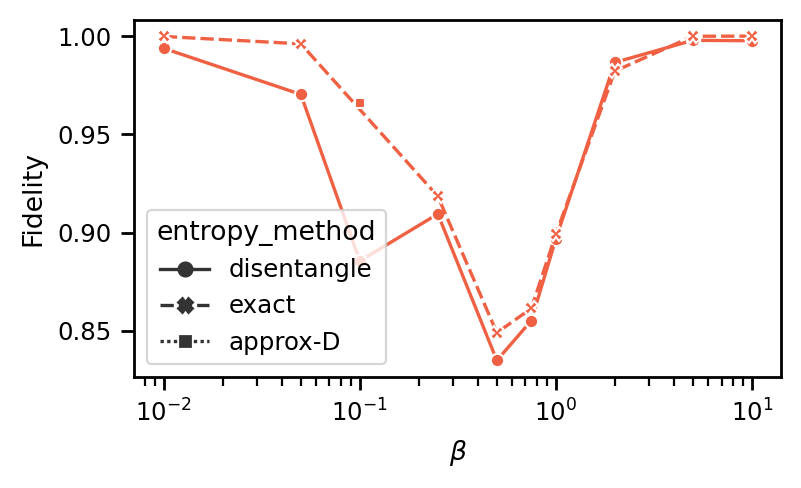

In [ ]:
#print(df.where(df["beta"]==10))
#df10 = df.where(df["beta"]==10)
#print(df10.iloc[np.argmin(df10.FinalCost)])
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (2*5.3/2.54,2*3/2.54)
mpl.rcParams.update({'font.size': 6})

sns.axes_style("whitegrid")
sns.set_context("paper")
sns.set_palette("rocket_r",2)

fig = plt.figure()
#fig.set_alpha(0.0)
#print(df.groupby(['beta', 'optimizer']))
beta_arr = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
df_max = df.loc[df.groupby(['beta', 'optimizer'])['FinalCost'].idxmin()]
print(df_max)
df_max = df_max[df_max['beta'].isin(beta_arr)]
#df_max=df.where(df["F"]>0.7)
colors = {"COBYLA":"#774360" , "L-BFGS-B ": "#0066CC"}
ax = sns.lineplot(data = df_max, x = 'beta', y ='F', markers = True ,style='entropy_method',legend = True,palette=colors)
#ax.set_facecolor('none') 
#plt.legend(title='Nonunitary:',  fontsize=6,loc='center left', labels=['Phaseflip, weakly symmetric', 'Bitflip, strongly symmetric'])
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

#plt.ylim((0.8,1.01))
filename = "Comparing_Optimizers.pdf"
#plt.savefig(graphs_dir + filename,  facecolor=fig.get_facecolor()  ,bbox_inches='tight')
plt.show()